In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

In [2]:
def extract_integer_from_string(s):
    # Find the first digit in the string
    start = next((i for i, c in enumerate(s) if c.isdigit()), None)

    if start is not None:
        # Use slicing to extract the numeric part of the string
        numeric_part = s[start:]

        # Convert the numeric part to an integer
        result = int(numeric_part)
        return result
    else:
        # No digits found in the string
        return None

Total reward for all walks: 1.0255


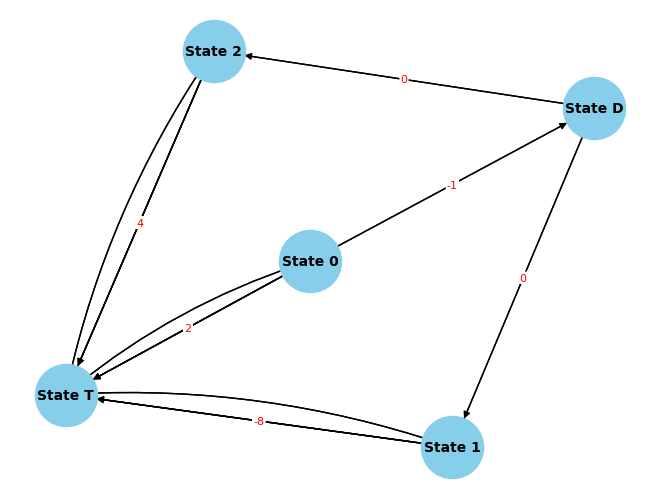

In [3]:
class DecisionTree:

    def __init__(self):
        # Create a directed graph with 5 nodes
        self.reset()


    def reset(self):
        # Generate nodes
        self.graph = nx.MultiDiGraph()

        nodes = ['State 0', 'State D', 'State 1', 'State 2', 'State T']

        # Add nodes to the graph without rewards
        self.graph.add_nodes_from(nodes)

        # Set rewards for all nodes to 0
        # for node in nodes:
        #     self.graph.nodes[node]['reward'] = 0

        # Add directed edges with rewards and probabilities
        edges = [
            ('State 0', 'State T', {'reward': 1, 'probability': 1/3}),
            ('State 0', 'State T', {'reward': 2, 'probability': 1/3}),
            ('State 0', 'State D', {'reward': -1, 'probability': 1/3}),
            ('State D', 'State 1', {'reward': 0, 'probability': 1/2}),
            ('State D', 'State 2', {'reward': 0, 'probability': 1/2}),
            ('State 1', 'State T', {'reward': 8, 'probability': 1/2}),
            ('State 1', 'State T', {'reward': -8, 'probability': 1/2}),
            ('State 2', 'State T', {'reward': 0, 'probability': 1/2}),
            ('State 2', 'State T', {'reward': 4, 'probability': 1/2}),
        ]

        self.graph.add_edges_from(edges)


    def simulate_walk(self, start_node = 'State 0'):
        current_node = start_node
        # step_reward = 0

        # Get all edges starting from the current node
        outgoing_edges = list(self.graph.out_edges(current_node, data=True))

        if not outgoing_edges:
            return step_reward, current_node, None
        
        # Choose an outgoing edge based on probabilities
        chosen_edge = random.choices(outgoing_edges, [edge[2]['probability'] for edge in outgoing_edges])[0]

        # Get the index of the chosen edge
        chosen_edge_index = outgoing_edges.index(chosen_edge)

        # Extract information from the chosen edge
        next_node = chosen_edge[1]
        # print(next_node)
        edge_reward = chosen_edge[2]['reward']

        # # Check if 'reward' attribute is present in the next_node dictionary
        # self.graph.nodes[next_node]['reward'] = edge_reward #+ self.graph.nodes[current_node]['reward'] 
        # step_reward += edge_reward

        # Move to the next node
        current_node = next_node

        return edge_reward, current_node, chosen_edge_index



    def visualize_graph(self):
        pos = nx.spring_layout(self.graph)

        # Draw nodes
        nx.draw(self.graph, pos, with_labels=True, font_weight='bold', node_size=2000, node_color='skyblue', font_color='black', font_size=10)

        # Draw edges with slight offsets for parallel edges
        for edge in self.graph.edges(keys=True):
            parallel_edges = [(edge[0], edge[1], k) for k in range(self.graph.number_of_edges(edge[0], edge[1]))]
            for i, (source, target, k) in enumerate(parallel_edges):
                offset = i * 0.1  # Adjust the offset based on your preference
                nx.draw_networkx_edges(self.graph, pos, edgelist=[(source, target, k)], edge_color='black', width=1, connectionstyle=f'arc3,rad={offset}')

                # Add edge labels manually with curved lines
                x = (pos[source][0] + pos[target][0]) / 2.0
                y = (pos[source][1] + pos[target][1]) / 2.0
                label = self.graph[source][target][k]['reward']
                
                # Draw a curved line connecting the text label and the midpoint of the edge
                plt.annotate(
                    text=f"{label}",
                    xy=(x, y),
                    xytext=(x, y),
                    color='red',
                    fontsize=8,
                    ha='center',
                    va='center',
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1'),
                    arrowprops=dict(arrowstyle='->', connectionstyle=f'arc3,rad={offset}')
                )

        # Add node labels
        labels = nx.get_node_attributes(self.graph, 'reward')
        nx.draw_networkx_labels(self.graph, pos, labels=labels)

        # Show the plot
        plt.show()


#Test the Simulated walk (mean should be 1)
rewards = []
for i in range(10000):
    # Create an instance of the DecisionTree class and visualize the graph
    decision_tree_instance = DecisionTree()
    # decision_tree_instance.visualize_graph()
    total_reward = 0
    current_state = 'State 0'
    while current_state != 'State T':
    # Simulate a walk
        step_reward, current_state, _ = decision_tree_instance.simulate_walk(start_node = current_state)
        total_reward = total_reward + step_reward
        # print(total_reward)
    rewards.append(total_reward)
    # print(decision_tree_instance.graph.nodes['State T'])
    # print(total_reward)

rewards = np.array(rewards)
print(f"Total reward for all walks: {rewards.mean()}")

# Correct usage with an instance
tree_instance = DecisionTree()
tree_instance.visualize_graph()


In [4]:
class policy_eval_agent:

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.reset()
    
    def reset(self):
        self.v = np.zeros(4) # make 4 entries: empty state 0 (for when trial is terminated) and states 1-3
    
    def eval_policy(self, u, u_prime, reward, lr=None):
        lr = lr if lr is not None else self.learning_rate
        delta = reward + self.v[u_prime] - self.v[u]
        self.v[u] += lr * delta
        return delta


In [5]:
agent = policy_eval_agent(learning_rate = 0.2)

tree = DecisionTree()

n_trials = 800
repetitions = 800
prediction_history = np.zeros((3, repetitions, n_trials+1))
for i in range(repetitions):
    for trial in range(n_trials):
        current_state = 'State 0'
        prediction_history[:,i,trial] = agent.v[:3]

        while current_state != 'State T':

            u = extract_integer_from_string(current_state)
            step_reward, current_state, _ = tree.simulate_walk(start_node = current_state)
            if current_state == 'State D':
                no_step_reward, current_state, _ = tree.simulate_walk(start_node = current_state)
                u_prime = extract_integer_from_string(current_state) if current_state != 'State T' else 3
                agent.eval_policy(u, u_prime, step_reward)
                continue
            u_prime = extract_integer_from_string(current_state) if current_state != 'State T' else 3
            agent.eval_policy(u, u_prime, step_reward)
    prediction_history[:,i,n_trials] = agent.v[:3]
    agent.reset()

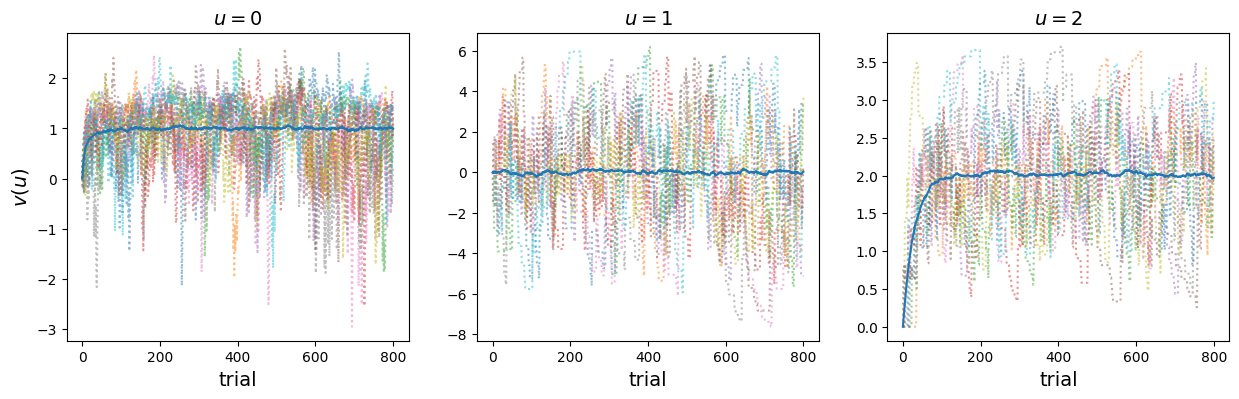

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
for u in range(3):
    axs[u].set_title(f"$u = {u:d}$", fontsize=14)
    for i in range(10):
        axs[u].plot(range(n_trials+1), prediction_history[u,i,:], ":", alpha= 0.5)
    axs[u].plot(range(n_trials+1), prediction_history[u,:,:].mean(axis=0), "-")
    axs[u].set_xlabel("trial", fontsize=14)
axs[0].set_ylabel("$v(u)$", fontsize=14)
plt.show()

In [7]:
class actor_critic_agent():

    def __init__(self, learning_rate_c, decay, learning_rate_a, beta):
        self.learning_rate_c = learning_rate_c
        self.learning_rate_a = learning_rate_a
        self.decay = decay
        self.beta = beta
        self.reset()
    
    def reset(self):
        self.v = np.zeros(4)
        self.m = {0: np.zeros(3), 1: np.zeros(2), 2: np.zeros(2)}
    
    def update_actor(self, u, u_prime, reward, choosen_edge):
        delta = reward + self.v[u_prime] - self.v[u]
        self.v[u] += self.learning_rate_c * delta
        for i in range(len(self.m[u])):
            self.m[u][i] = (1 - self.decay) * self.m[u][i]
            self.m[u][i] += self.learning_rate_a * delta if choosen_edge == i else 0

    def update_steps(self, tree, previous_state):
        u = extract_integer_from_string(previous_state)
        mv = self.m[u]
        pv = np.exp(self.beta * mv)
        pv /= pv.sum()

        outgoing_edges = list(tree.graph.out_edges(previous_state, data=True))
        # print(outgoing_edges)

        for i, (source_node, target_node, edge_data) in enumerate(outgoing_edges):
            # Update the probability in the edge data
            edge_data['probability'] = pv[i]
            # print((source_node, target_node, edge_data))




In [8]:
ac_agent = actor_critic_agent(learning_rate_c = 0.2, decay = 0, learning_rate_a= 0.075, beta= 1)

tree = DecisionTree()

n_trials = 1000
repetitions = 1000
prediction_history = np.zeros((3, repetitions, n_trials+1))
m_history = {0: np.zeros((3, repetitions, n_trials+1)), 1: np.zeros((2, repetitions, n_trials+1)), 2: np.zeros((2, repetitions, n_trials+1))}

for i in range(repetitions):
    for trial in range(n_trials):
        current_state = 'State 0'

        prediction_history[:,i,trial] = ac_agent.v[:3].copy()
        for state in range(3):
            m_history[state][:,i,trial] = ac_agent.m[state].copy()
        
        while current_state != 'State T':


            u = extract_integer_from_string(current_state)
            previous_state = current_state
            step_reward, current_state, choosen_edge = tree.simulate_walk(start_node = current_state)

            if current_state == 'State D': 
                _, current_state, _ = tree.simulate_walk(start_node = current_state)
 
            u_prime = extract_integer_from_string(current_state) if current_state != 'State T' else 3
            ac_agent.update_actor(u, u_prime, step_reward, choosen_edge)
            ac_agent.update_steps(tree, previous_state)  



    prediction_history[:,i,n_trials] = ac_agent.v[:3].copy()
    for state in range(3):
        m_history[state][:,i,n_trials] = ac_agent.m[state].copy()
    ac_agent.reset()
    # Print edges and their edge data
    # print("Edges and Edge Data:")
    # for edge in tree.graph.edges(data=True):
    #     print(edge)
        
    tree.reset()




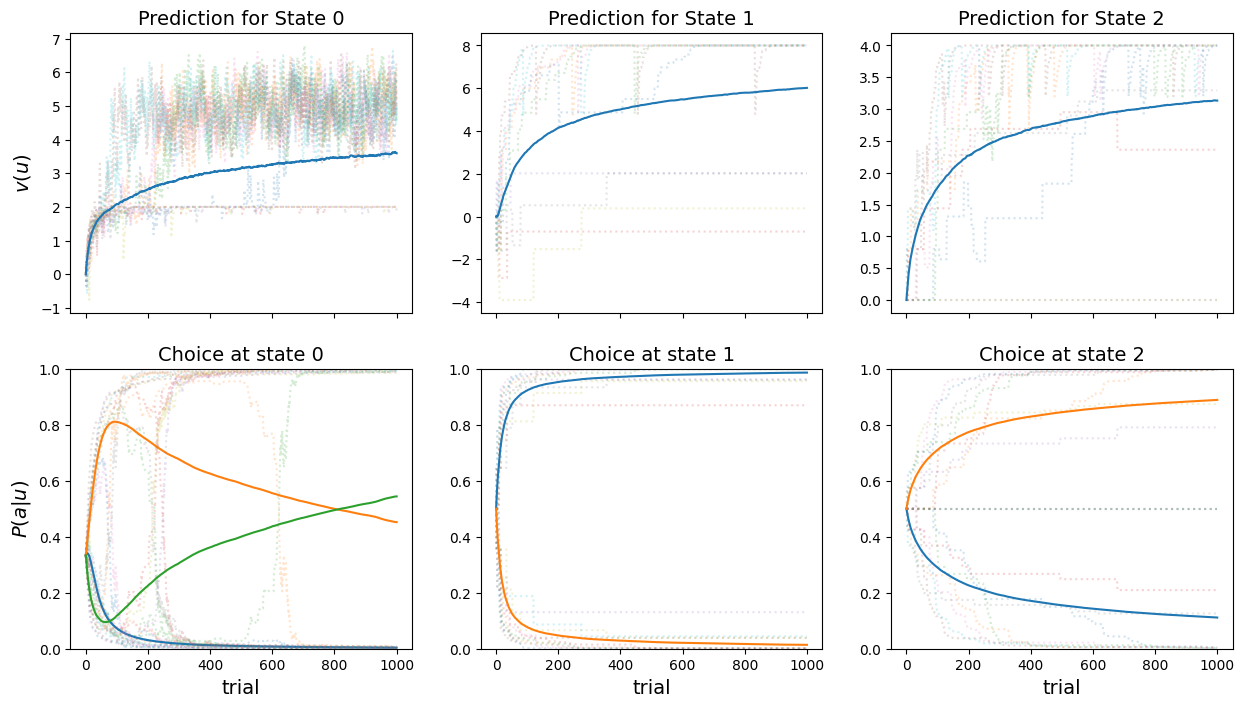

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex=True)

for i in range(3):
    axs[0,i].set_title(f"Prediction for State {i:d}", fontsize=14)
    for j in range(10):
        axs[0,i].plot(range(n_trials+1), prediction_history[i,j,:], ":", alpha = 0.2)
    axs[0,i].plot(range(n_trials+1), prediction_history[i,:,:].mean(axis=0), "-")
axs[0,0].set_ylabel("$v(u)$", fontsize=14)

for i in range(3):
    axs[1,i].set_title(f"Choice at state {i:d}", fontsize=14)

    mv = m_history[i]
    pv = np.exp(ac_agent.beta*mv) / np.sum(np.exp(ac_agent.beta*mv), axis=0)
    for j in range(pv.shape[0]):
        for k in range(10):
            axs[1,i].plot(range(n_trials+1), pv[j,k,:], ":", alpha = 0.2)
        axs[1,i].plot(range(n_trials+1), pv[j,:,:].mean(axis=0), "-")
        axs[1,i].set_xlabel("trial", fontsize=14)
        axs[1,i].set_ylim(0,1)
axs[1,0].set_ylabel("$P(a|u)$", fontsize=14)
fig.align_ylabels(axs)
plt.show()

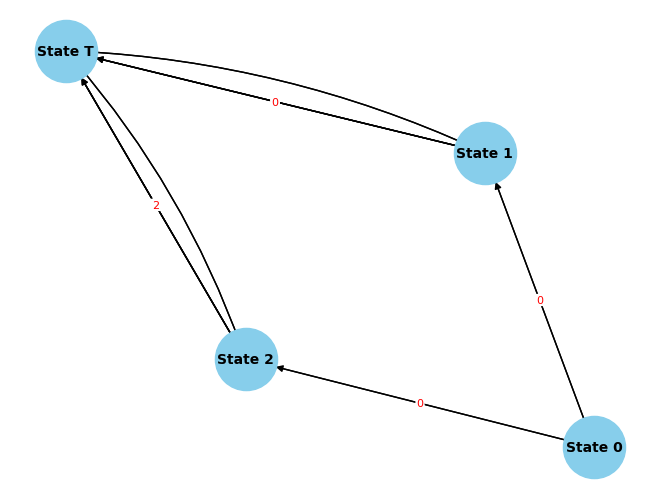

In [17]:
class Maze:

    def __init__(self):
        # Create a directed graph with 5 nodes
        self.reset()


    def reset(self):
        # Generate nodes
        self.graph = nx.MultiDiGraph()

        nodes = ['State 0', 'State 1', 'State 2', 'State T']

        # Add nodes to the graph without rewards
        self.graph.add_nodes_from(nodes)

        edges = [
            ('State 0', 'State 1', {'reward': 0, 'probability': 1/2}),
            ('State 0', 'State 2', {'reward': 0, 'probability': 1/2}),
            ('State 1', 'State T', {'reward': 4, 'probability': 1/2}),
            ('State 1', 'State T', {'reward': 0, 'probability': 1/2}),
            ('State 2', 'State T', {'reward': 3, 'probability': 1/2}),
            ('State 2', 'State T', {'reward': 2, 'probability': 1/2})
        ]

        self.graph.add_edges_from(edges)


    def simulate_walk(self, start_node = 'State 0'):
        current_node = start_node
        # step_reward = 0

        # Get all edges starting from the current node
        outgoing_edges = list(self.graph.out_edges(current_node, data=True))

        if not outgoing_edges:
            return step_reward, current_node, None
        
        # Choose an outgoing edge based on probabilities
        chosen_edge = random.choices(outgoing_edges, [edge[2]['probability'] for edge in outgoing_edges])[0]

        # Get the index of the chosen edge
        chosen_edge_index = outgoing_edges.index(chosen_edge)

        # Extract information from the chosen edge
        next_node = chosen_edge[1]
        # print(next_node)
        edge_reward = chosen_edge[2]['reward']

        # # Check if 'reward' attribute is present in the next_node dictionary
        # self.graph.nodes[next_node]['reward'] = edge_reward #+ self.graph.nodes[current_node]['reward'] 
        # step_reward += edge_reward

        # Move to the next node
        current_node = next_node

        return edge_reward, current_node, chosen_edge_index



    def visualize_graph(self):
        pos = nx.spring_layout(self.graph)

        # Draw nodes
        nx.draw(self.graph, pos, with_labels=True, font_weight='bold', node_size=2000, node_color='skyblue', font_color='black', font_size=10)

        # Draw edges with slight offsets for parallel edges
        for edge in self.graph.edges(keys=True):
            parallel_edges = [(edge[0], edge[1], k) for k in range(self.graph.number_of_edges(edge[0], edge[1]))]
            for i, (source, target, k) in enumerate(parallel_edges):
                offset = i * 0.1  # Adjust the offset based on your preference
                nx.draw_networkx_edges(self.graph, pos, edgelist=[(source, target, k)], edge_color='black', width=1, connectionstyle=f'arc3,rad={offset}')

                # Add edge labels manually with curved lines
                x = (pos[source][0] + pos[target][0]) / 2.0
                y = (pos[source][1] + pos[target][1]) / 2.0
                label = self.graph[source][target][k]['reward']
                
                # Draw a curved line connecting the text label and the midpoint of the edge
                plt.annotate(
                    text=f"{label}",
                    xy=(x, y),
                    xytext=(x, y),
                    color='red',
                    fontsize=8,
                    ha='center',
                    va='center',
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1'),
                    arrowprops=dict(arrowstyle='->', connectionstyle=f'arc3,rad={offset}')
                )

        # Add node labels
        labels = nx.get_node_attributes(self.graph, 'reward')
        nx.draw_networkx_labels(self.graph, pos, labels=labels)

        # Show the plot
        plt.show()



# Correct usage with an instance
maze_instance = Maze()
maze_instance.visualize_graph()

In [13]:
class actor_critic_agent_maze():

    def __init__(self, learning_rate_c, decay, learning_rate_a, beta):
        self.learning_rate_c = learning_rate_c
        self.learning_rate_a = learning_rate_a
        self.decay = decay
        self.beta = beta
        self.reset()
    
    def reset(self):
        self.v = np.zeros(4)
        self.m = {0: np.zeros(2), 1: np.zeros(2), 2: np.zeros(2)}
    
    def update_actor(self, u, u_prime, reward, choosen_edge):
        delta = reward + self.v[u_prime] - self.v[u]
        self.v[u] += self.learning_rate_c * delta
        for i in range(len(self.m[u])):
            self.m[u][i] = (1 - self.decay) * self.m[u][i]
            self.m[u][i] += self.learning_rate_a * delta if choosen_edge == i else 0

    def update_steps(self, tree, previous_state):
        u = extract_integer_from_string(previous_state)
        mv = self.m[u]
        pv = np.exp(self.beta * mv)
        pv /= pv.sum()

        outgoing_edges = list(tree.graph.out_edges(previous_state, data=True))
        # print(outgoing_edges)

        for i, (source_node, target_node, edge_data) in enumerate(outgoing_edges):
            # Update the probability in the edge data
            edge_data['probability'] = pv[i]
            # print((source_node, target_node, edge_data))


In [14]:
ac_agent_maze = actor_critic_agent_maze(learning_rate_c = 0.2, decay = 0, learning_rate_a= 0.075, beta= 1)

maze = Maze()

n_trials = 1000
repetitions = 1000
prediction_history_maze = np.zeros((3, repetitions, n_trials+1))
m_history_maze = {0: np.zeros((2, repetitions, n_trials+1)), 1: np.zeros((2, repetitions, n_trials+1)), 2: np.zeros((2, repetitions, n_trials+1))}

for i in range(repetitions):
    for trial in range(n_trials):
        current_state = 'State 0'

        prediction_history_maze[:,i,trial] = ac_agent_maze.v[:3].copy()
        for state in range(3):
            m_history_maze[state][:,i,trial] = ac_agent_maze.m[state].copy()
        
        while current_state != 'State T':


            u = extract_integer_from_string(current_state)
            previous_state = current_state
            step_reward, current_state, choosen_edge = maze.simulate_walk(start_node = current_state)
            u_prime = extract_integer_from_string(current_state) if current_state != 'State T' else 3
            ac_agent_maze.update_actor(u, u_prime, step_reward, choosen_edge)
            ac_agent_maze.update_steps(maze, previous_state)  



    prediction_history_maze[:,i,n_trials] = ac_agent_maze.v[:3].copy()
    for state in range(3):
        m_history_maze[state][:,i,n_trials] = ac_agent_maze.m[state].copy()
    ac_agent_maze.reset()
    # Print edges and their edge data
    # print("Edges and Edge Data:")
    # for edge in tree.graph.edges(data=True):
    #     print(edge)
        
    maze.reset()



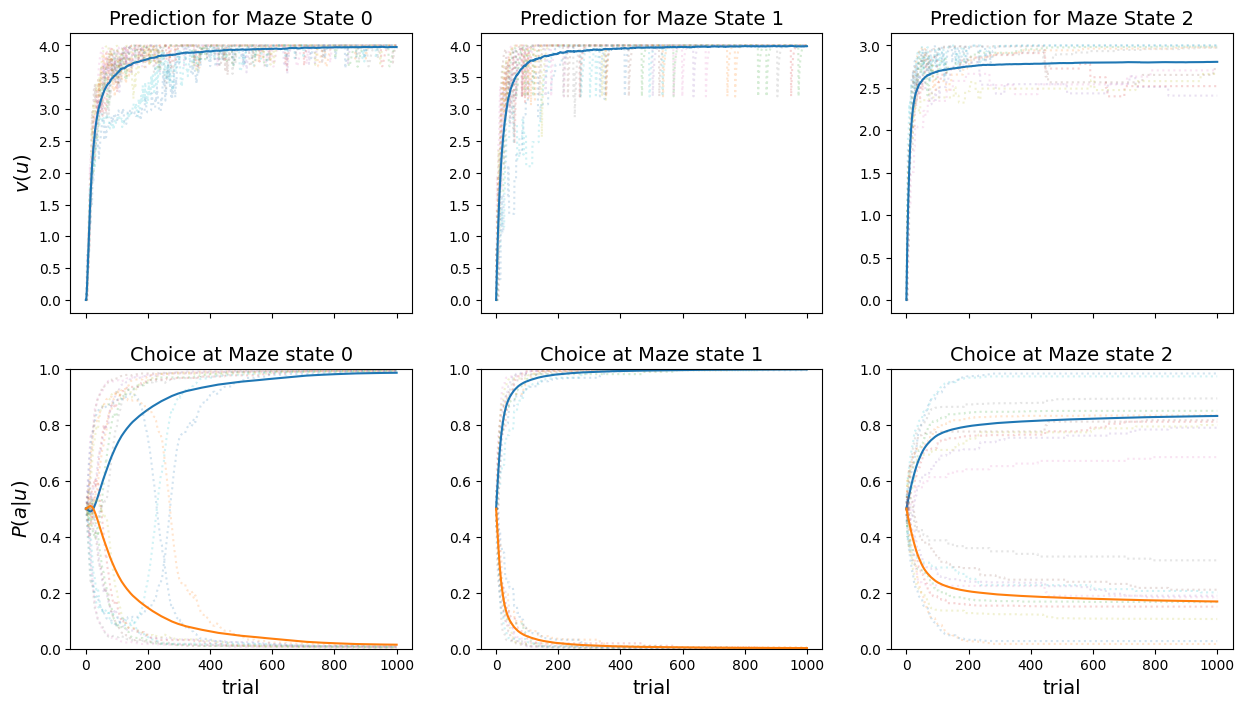

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex=True)

for i in range(3):
    axs[0,i].set_title(f"Prediction for Maze State {i:d}", fontsize=14)
    for j in range(10):
        axs[0,i].plot(range(n_trials+1), prediction_history_maze[i,j,:], ":", alpha = 0.2)
    axs[0,i].plot(range(n_trials+1), prediction_history_maze[i,:,:].mean(axis=0), "-")
axs[0,0].set_ylabel("$v(u)$", fontsize=14)

for i in range(3):
    axs[1,i].set_title(f"Choice at Maze state {i:d}", fontsize=14)

    mv = m_history_maze[i]
    pv = np.exp(ac_agent_maze.beta*mv) / np.sum(np.exp(ac_agent_maze.beta*mv), axis=0)
    for j in range(pv.shape[0]):
        for k in range(10):
            axs[1,i].plot(range(n_trials+1), pv[j,k,:], ":", alpha = 0.2)
        axs[1,i].plot(range(n_trials+1), pv[j,:,:].mean(axis=0), "-")
        axs[1,i].set_xlabel("trial", fontsize=14)
        axs[1,i].set_ylim(0,1)
axs[1,0].set_ylabel("$P(a|u)$", fontsize=14)
fig.align_ylabels(axs)
plt.show()